In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import h5py, bisect, heapq
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, KFold
from scipy.stats import iqr
np.random.seed(32815)

In [2]:
with h5py.File('digits.h5')as f:
    images = f['images'].value
    labels = f['labels'].value

def pic_reshape(images):
    s = images.shape
    return images.reshape(s[0], s[1] * s[2])
# normalize data
images = pic_reshape(images)/np.max(images)
print(images.shape)

(120000, 81)


Choose digit for this exercise and filter data

In [3]:
digit = 6

In [4]:
mask = labels == digit
x = images[mask]
y = labels[mask]

Plot of random images from digit dataset

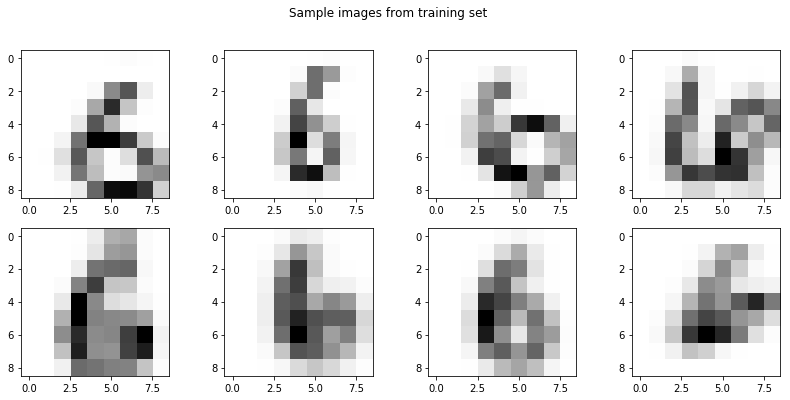

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
fig.suptitle("Sample images from training set")
for ax, choice in zip(axes.flatten(), np.random.choice(x.shape[0], 8)):
    ax.imshow(x[choice].reshape(9,9), cmap='Greys')

# 1. Data Generation with Naive Bayes

Using Histogram and NaiveBayesClassifier classes provided on Moodle (removed unused methods for readability

In [6]:
class Histogram(object):
    """Histogram.
    """

    def __init__(self, values):
        """Create a histogram for the given values using the Freedman-Diaconis rule for the bin width.

        :param values: the values from which the histogram will be computed
        """
        self.num_instances = len(values)

        # Get the number of bins.
        v_min, v_25, v_75, v_max = np.percentile(values, [0, 25, 75, 100])
        # freedman_diaconis_width = 2 * (v_75 - v_25) / (len(values) ** (1/3.0))
        freedman_diaconis_width = (v_max - v_min) / (len(values) ** (1/3.0))
        num_bins = int(round((v_max - v_min) / freedman_diaconis_width))
        assert num_bins > 0

        # Fill the bins.
        self.heights, self.bin_edges = np.histogram(values, bins=num_bins)
        # Normalize bins based on number of instances
        self.probs = self.heights / self.num_instances

class NaiveBayesClassifier(object):
    """Naive Bayes classifier.
    """

    def __init__(self):
        self.num_instances = None  # Number of instances that were used in training.
        self.num_feats = None  # Number of features that were used in training.
        self.classes = None  # The classes that were found in training.
        self.histograms = {}  # Dict with histograms, key: class, value: list with histograms for all features.
        self.priors = {}  # Dict with priors, key: class, value: prior of the class.

    def train(self, train_x, train_y):
        """Train the classifier.

        :param train_x: training x data
        :param train_y: training y data
        """
        assert train_x.shape[0] == len(train_y)
        self.num_instances = train_x.shape[0]
        self.num_feats = train_x.shape[1]
        self.classes = np.unique(train_y)

        # Create one histogram for each class and each feature.
        self.histograms.clear()
        for cl in self.classes:
            # Get the data of the current class.
            train_x_cl = [train_x[k] for k in range(self.num_instances) if train_y[k] == cl]
            num_instances_cl = len(train_x_cl)

            # Create one histogram per feature.
            self.histograms[cl] = []
            for i in range(self.num_feats):
                histo_points = [train_x_cl[k][i] for k in range(num_instances_cl)]
                self.histograms[cl].append(Histogram(histo_points))

In [7]:
# create naive bayes histograms
nb = NaiveBayesClassifier()
nb.train(x, y)

In [8]:
# function to sample image from histograms
# function has different arguments than on assignment,
# because of the provided NaiveBayes class
def sample_naive_bayes(nb, digit):
    # empty image
    image = np.empty(len(nb.histograms[digit]))
    
    # for all histograms
    for j, hist in enumerate(nb.histograms[digit]):
        r = np.random.random()
        # cumulative histogram
        cumhist = np.cumsum(hist.probs)
        l = 0
        # find smallest l with Q_l > random
        while cumhist[l] < r and l < len(cumhist)-1:
            l += 1
        # random sample between bin l boundaries
        image[j] = np.random.uniform(*hist.bin_edges[l:l+2])
    return image.reshape(9,9)

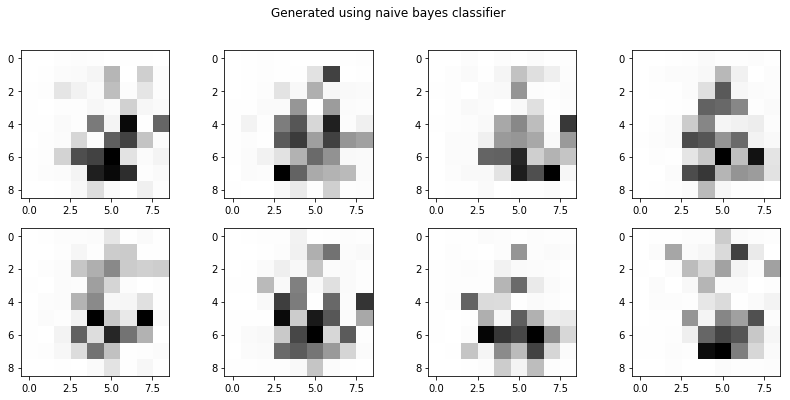

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
fig.suptitle("Generated using naive bayes classifier")
for ax in axes.flatten():
    ax.imshow(sample_naive_bayes(nb, digit), cmap='Greys')

# 2. Data Generation & Classification with Density Trees

In [10]:
class DataPass: # empty class which can be accessed by all tree nodes
    pass

class Node:
    "Tree node class"
    def __init__(self, data, bbox, dataobj=None):
        # tree children, private, accessed by properties left & right
        self.__left, self.__right = None, None
        self.data = data
        self.N = data.shape[0]
        # volume of bin
        self.vol = np.product(bbox[:,1]-bbox[:,0])
        assert(self.vol > 0)
        # bounding box
        self.bbox = np.array(bbox)
        # object to carry information for whole tree
        self.dataobj = dataobj
        
    def find_split(self, score_func, threshhold_count=10):
        """Find best split threshhold by searching for best score
           using score_func()"""
        threshholds = np.empty(self.bbox.shape[0])
        self.best_split = {'score' : -np.inf}
        # exhaustive search for best split score
        for j, box in enumerate(self.bbox):
            for t in np.linspace(*box, threshhold_count+2)[1:-1]:
                leftmask = self.data[:,j] < t
                V_red = self.vol / (box[1] - box[0])
                Vl = (t - box[0]) * V_red
                Vr = (box[1] - t) * V_red
                Nl = np.count_nonzero(leftmask)
                Nr = self.N - Nl
                score = score_func(self.vol, self.N, self.dataobj.Ntot, Nl, Vl, Nr, Vr) 
                if score > self.best_split['score']:
                    self.best_split['score'] = score
                    self.best_split['feature'] = j
                    self.best_split['threshhold'] = t
        # returns negative score & node in tuple for min heap
        return (-self.best_split['score'], self)
    
    def split(self):
        """Split leaf according to threshhold found in find_split.
           Returns False if one bin would be empty, doesn't perform split"""
        t = self.best_split['threshhold']
        j = self.best_split['feature']
        lmask = self.data[:,j] < t
        lcount = np.count_nonzero(lmask)
        if lcount == 0 or lcount == lmask.shape[0]:
            return False
        bbox_l, bbox_r = np.copy(self.bbox), np.copy(self.bbox)
        bbox_l[j, 1] = t
        bbox_r[j, 0] = t
        self.left = Node(self.data[lmask], bbox_l)
        self.right = Node(self.data[~lmask], bbox_r)
        # save threshhold and feature for prediction
        self.t, self.j = t, j
        # delete data, because it's not needed anymore (all data in leafs)
        del self.data
        return True
    
    "Property methods for probability"
    @property
    def prob(self):
        return self.N / self.dataobj.Ntot
    @property
    def prob_dens(self):
        return self.N / self.dataobj.Ntot / self.vol
    
    """Property methods for children, needed to implicitly carry dataobj"""
    @property
    def left(self):
        return self.__left
    
    @left.setter
    def left(self, node):
        self.__left = node
        self.__left.dataobj = self.dataobj
        
    @property
    def right(self):
        return self.__right
    
    @right.setter
    def right(self, node):
        self.__right = node
        self.__right.dataobj = self.dataobj

def fit_density_tree(features, tau, score_func):
    "Create tree from training data"
    bincount = int(tau * features.shape[0]**(1/3))
    # data boundaries
    bbox_root = np.empty((features.shape[1], 2))
    for i in range(features.shape[1]):
        bbox_root[i, 0] = np.min(features[:,i])
        bbox_root[i, 1] = np.max(features[:,i])
    
    
    obj = DataPass() # Data object accessible in all nodes
    obj.Ntot = features.shape[0]
    
    # create tree root
    root = Node(features, bbox_root, dataobj=obj)
    # initialize min heap for split
    leafs = [root.find_split(score_func)]
    
    # make max bincount splits
    i = 0
    while i < bincount-2 and len(leafs) != 0:
        _, node = heapq.heappop(leafs)
        if node.split() is False: # only count executed splits
            continue
        heapq.heappush(leafs, node.left.find_split(score_func))
        heapq.heappush(leafs, node.right.find_split(score_func))
        i += 1
    return root

In [11]:
def score_sqr(V, N, Ntot, Nl, Vl, Nr, Vr):
    "Scoring function to minimize squared error"
    p = N / Ntot / V
    pl = Nl / Ntot / Vl
    pr = Nr / Ntot / Vr
    return -(-p**2 * V**2 + pl**2 * Vl + pr**2 * Vr)
def fit_density_tree1(features, tau):
    return fit_density_tree(features, tau, score_sqr)

In [12]:
tree1 = fit_density_tree1(x, 50)

In [13]:
# Tree check functions
def traverse_tree(root, action):
    if root is None:
        return
    traverse_tree(root.left, action)
    action(root)
    traverse_tree(root.right, action)

def action(node):
    if node.left is None:
        print(node.N)

def prob_check(node):
    if node.left is None:
        return
    else:
        assert(node.prob - node.left.prob - node.right.prob < 1e-16)
traverse_tree(tree1, prob_check)

In [14]:
def sample_density_tree(node):
    "Sample image from density tree"
    t = np.random.random()
    # find leaf using tree probabilities
    while node.left is not None:
        if t <= node.prob:
            node = node.left
        else:
            t -= node.prob
            node = node.right
    # sample uniformly from bin
    return np.fromiter((np.random.uniform(*box) for box in node.bbox),
                       dtype='float', count=node.bbox.shape[0]).reshape(9,9)

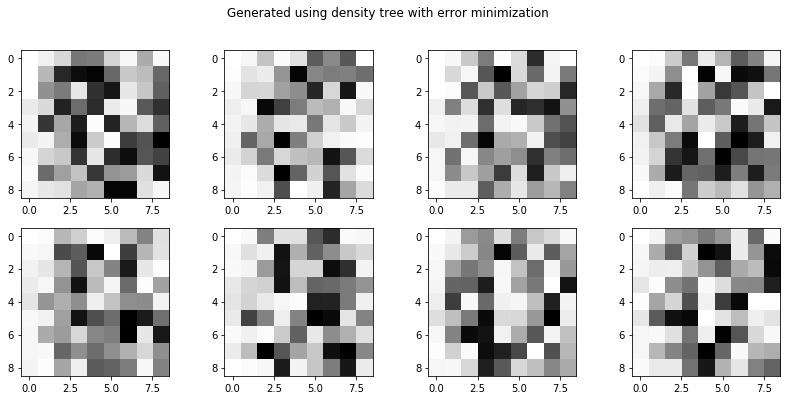

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
fig.suptitle("Generated using density tree with error minimization")
for ax in axes.flatten():
    ax.imshow(sample_density_tree(tree1), cmap='Greys')

Something went wrong in the tree fitting process, we can't track exactly where, most likely with the exhaustive search for the best split. 
So the generated images look almost like random noise, and worse than the images from the naive bayes generator.

## 2.2 Train Tree by Maximizing Non-Uniformity

In [16]:
def score_uniformity(V, N, Ntot, Nl, Vl, Nr, Vr):
    "Scoring to Maximize non-Uniformity"
    return (Nl * V - N * Vl)**2 / (Vl * (V - Vl))
def fit_density_tree2(features, tau):
    return fit_density_tree(features, tau, score_sqr)

In [17]:
tree2 = fit_density_tree2(x,50)

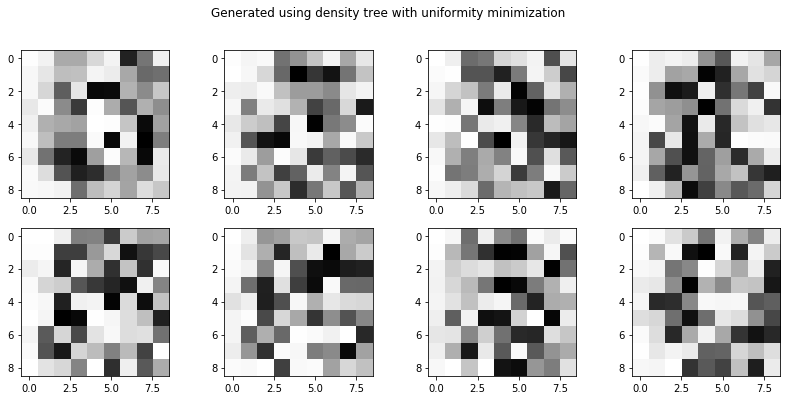

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
fig.suptitle("Generated using density tree with uniformity minimization")
for ax in axes.flatten():
    ax.imshow(sample_density_tree(tree2), cmap='Greys')

## 2.3 Tree-Based Classification

In [19]:
def tree_find_prob_dens(node, x):
    "Find bin for test sample, return probability of bin"
    while node.left is not None:
        if x[node.j] < node.t:
            node = node.left
        else:
            node = node.right
    return node.prob_dens

def predict_density_trees(features, tree3, tree9):
    prediction = np.empty(features.shape[0])
    for i, x in enumerate(features):
        prediction[i] = 3 if tree_find_prob_dens(tree3, x) > tree_find_prob_dens(tree9, x) else 9
    return prediction

In [20]:
tree3 = fit_density_tree1(images[labels == 3], 20)
tree9 = fit_density_tree1(images[labels == 9], 20)

In [21]:
with h5py.File('digits_test.h5')as f:
    test_images = f['images'].value
    test_labels = f['labels'].value

# normalize and reshape
test_images = pic_reshape(test_images)/np.max(images)
mask = (test_labels == 3) | (test_labels == 9)
test_x = test_images[mask]
test_y = test_labels[mask]


prediction = predict_density_trees(test_x, tree3, tree9)

In [22]:
def confusion_matrix(predicted, truth, nice_print=False, labels=[3,9]):
    conf = np.empty((len(labels), len(labels)))
    # calculate decision matrix
    for i, label in enumerate(labels):
        _, conf[i] = np.unique(predicted[truth == label], return_counts=True)
    
    conf /= predicted.shape[0]
    # print confusion matrix using pandas
    if nice_print:
        display(pd.DataFrame(data = conf, index=labels, columns=labels
                            ).rename_axis("Truth/Predicted", axis='columns'))
    return conf

In [23]:
confusion_matrix(prediction, test_y, nice_print=True);

Truth/Predicted,3,9
3,0.500248,0.500248
9,0.499752,0.499752


The prediction with the density tree is worse than with the naive bayes classifier, but this most likely comes from an implementation error in the tree fitting algorithm

# 3. Data Generation with a Multi-dimensional Gaussian

In [24]:
# Fit feature of one label to multi-dim gaussian
def fit_gaussian(features):
    means = np.mean(features, axis=0) # calculate means
    cov = np.cov(features.T)          # calculate covariance matrix
    return means, cov

# sample from multi-dim gaussian, return image
def sample_qda(mean, cov):
    return np.random.multivariate_normal(mean, cov).reshape(9,9)

In [25]:
means, cov = fit_gaussian(x)

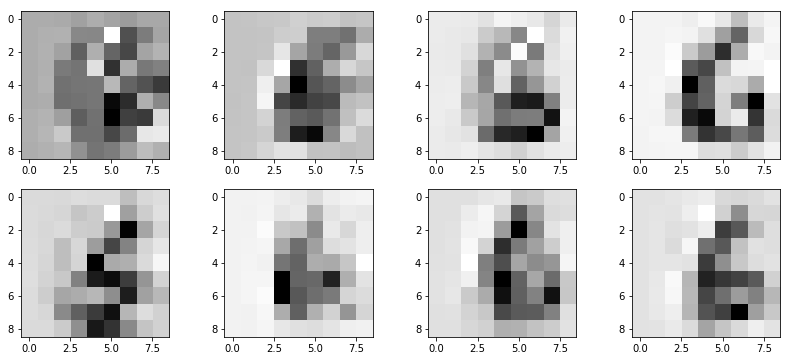

In [26]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
for ax in axes.flatten():
    ax.imshow(sample_qda(means, cov), cmap='Greys')